# Introduction

In statistics, and particularly, in biomedical research, composite scores are commonly calculated from multiple variables in order to form simple, reliable and valid measures of latent, theoretical constructs (Song et al., 2013, Babbie, 2016).

A common approach is, for instance, to convert each variable to a z-score and then unit-weight the variables (i.e., take a simple sum of z-scores). This represents an equal weighting that controls for the fact that the variables are on different metrics (Bobko et al, 2007).

Such and similar composite scores are frequently used in pain research, as well, e.g. to describe the quality of pain (Victor et al., 2008), intensity of postsurgical (Jensen et al., 2002) and chronic pain (Jensen et al., 1999), disease activity (Haugen et al., 2010), or pain sensitivity (O’Neill, 2014,Starkweather et al., 2016, Zunhammer et al., 2016). The benefit of such  scores is in their ability to capture multiple aspects of interest into a single numerical value, which might increase the face and construct validity and sensitivity to change (Haugen et al., 2010). 
Although these scores are mostly based on well-established and validated measurement protocols like the Quantitative Sensory Testing (QST, Rolke et al., 2006) (Jensen et al., 2002, Jensen et al., 1999, O’Neill, 2014,Starkweather et al., 2016, Zunhammer et al., 2016), the composition of these scores depends on the specific aims of studies.

For instance the QST-based pain sensitivity score proposed in (Zunhammer et al., 2016) is a unit weighted measure of the z-score transformed pain thresholds assessed in three different sensory modalities, namely heat, cold and mechanical pain thresholds (HPT, CPT and MPT, respectively). This composite score was shown to be strongly associated to combined glutamate and glutamine levels in pain processing regions and, importantly, it was found to *outperform* the single modalities it is based on (Zunhammer et al., 2016, Supplemental Digital Content 3).

While this indirect evidence suggests that this pain sensitivity score might be a useful measure of the modality-independent component shaping one's sensitivity to pain, a thorough characterization of the the effectiveness of this composite score still needs to be done, before using it as gold-standard proxy variable for modality-independent pain sensitivity e.g. in predictive modeling studies.

# Aim

In this python notebook, we perform a *multi-stage* analysis to investigate the rationale of using the composite pain sensitivity score as defined by (Zunhammer et al., 2016) for predictive modeling purposes like the *RPN-signature*.


# Overview of the analysis

Most of the composite scales are assumed by their developers and users to be primarily a measure of *one latent variable*. When it is also assumed that the scale conforms to the effect indicator model of measurement (as is almost always the case in psychological assessment), it is important to support such an interpretation with evidence regarding the internal structure of that scale (Zinbarg et al., 2006). 

After importing necessary python modules and loading the data, here we perform four stages of analysis, addressing four key question:
- **Question Q1.** Is there a common, modality-independent component shared across the investigated pain modalities?
- **Question Q2.** Do the the composite score of (Zunhammer et al., 2016) capture this putative, shared, modality-independent component?
- **Question Q3.** Do we have evidence that the prediction of the RPN-signature (the RPN-score, trained using the the score of (Zunhammer et al., 2016)) captures the shared, modality-independent component?
- **Question Q4.** To what extent is the RPN-score biased towards any of the modalities? Is its correlation with the single thresholds lower than expected from its correlation to the Zunhammer-score?


# Import neccessary modules and load data.

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns; sns.set()
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')
from mlxtend.evaluate import permutation_test
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import statsmodels.api as sm

# Load all data:
study1 = pd.read_csv("../res/bochum_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom",
                                                       "mean_QST_pain_sensitivity", "prediction"]]
study2 = pd.read_csv("../res/essen_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom",
                                                      "mean_QST_pain_sensitivity", "prediction"]]
study3 = pd.read_csv("../res/szeged_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom",
                                                       "mean_QST_pain_sensitivity", "prediction"]]
# merge datasets
study1["study"]="Study 1"
study2["study"]="Study 2"
study3["study"]="Study 3"
df = pd.concat([study1, study2, study3])
df = df.dropna()

# Question Q1: Is there a common, modality-independent component shared across the investigated pain modalities?

We invetsigate heat, cold and mechanical pain thresholds (HPT, CPT and MPT, respecuvely), as measured via Quantitative Sensory Testing (QST) with the aim of identifying any "modality-independent" component, shared across the these measurements.

Specifically, we assume that all three variables consist of three compomnents:
- a modality-specific component (different for heat, cold and mechanical stimuli)
- a modality-independent component (shared between heat, cold and mechanical stimuli)
- an additional "noise" component (e.g. confounds specific for the different measures, like reaction time confounds, skin physiology, etc.)

**Biological Rationale:**

**@Matthias: HERE I NEED YOUR HELP!** Like fiber types etc...


## Step 1. McDonald's omega

McDonald's Omega as a measure of internal consistency. It measures whether several items that propose to measure the same general construct produce similar scores. 

**Possible outcomes and interpretations:**
The value of McDonald's Omega falls between 0 and 1. While there are rules of thumb for cut-off values, those are more appropriate for variables which are meant to measure exactly the same latent variable. In general, larger values mean stronger internal consistency and a value below 0.5 indicates the lack of internal consistency across the variables.

**R-code:**

> ``` 
# load data into data.frame called df
library(psych)
omega(df)
```

### Results

Omega ('omega total') was found to be **0.62**.

### Interpretation

This value suggest internal consistency across the investigated pain threshold measures.

To gain a more detailed insight into the consistency structure, below, we investigate:
- the correlations between the variables (Step 2),
- and the underlying latent components by means of principal component analysis (Step 3).


## Step 2. Correlation analysis

Below we compute the correlation between all possible pairs of pain thresholds, as well as the mean correlation across all possible pairs.
P-values are calculated via permutation testing.

cor(HPT, CPT) = -0.5063125884777612
Permuation-based p = 0.0
cor(HPT, MPT_log_geom) = 0.19267290368321235
Permuation-based p = 0.0336
cor(CPT, MPT_log_geom) = -0.06731140025472557
Permuation-based p = 0.2651
Mean correlation: 0.2554322974718997
Permuation-based p = 0.0


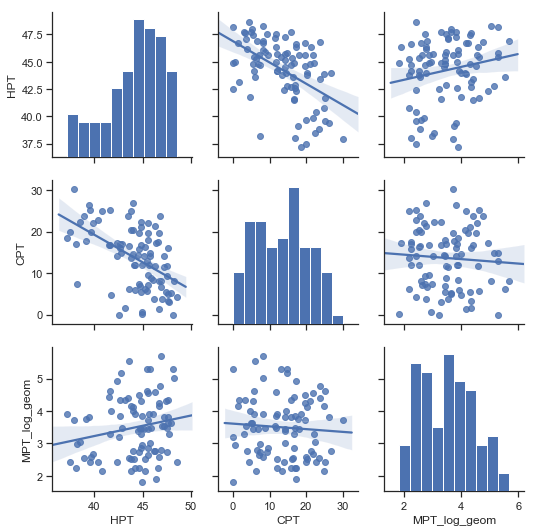

In [5]:
sns.pairplot(df[["HPT", "CPT", "MPT_log_geom", "study"]], kind="reg") 
# tip: add hue="study", to see data separately for each study

p_value = permutation_test(df['HPT'], df['CPT'],
                           method='approximate',
                           func=lambda x, y: -np.corrcoef(x, y)[1][0],
                           num_rounds=10000,
                           seed=0)
print("cor(HPT, CPT) = " + str(np.corrcoef(df['HPT'], df['CPT'])[0,1]))
print("Permuation-based p = " + str(p_value))

p_value = permutation_test(df['HPT'], df['MPT_log_geom'],
                           method='approximate',
                           func=lambda x, y: np.corrcoef(x, y)[1][0],
                           num_rounds=10000,
                           seed=0)
print("cor(HPT, MPT_log_geom) = " + str(np.corrcoef(df['HPT'], df['MPT_log_geom'])[0,1]))
print("Permuation-based p = " + str(p_value))

p_value = permutation_test(df['CPT'], df['MPT_log_geom'],
                           method='approximate',
                           func=lambda x, y: -np.corrcoef(x, y)[1][0],
                           num_rounds=10000,
                           seed=0)
print("cor(CPT, MPT_log_geom) = " + str(np.corrcoef(df['CPT'], df['MPT_log_geom'])[0,1]))
print("Permuation-based p = " + str(p_value))

p_value = permutation_test(df['HPT'], df['CPT'], 
                           method='approximate',
                           func=lambda x, y: np.mean(np.abs([np.corrcoef(x, y)[0,1],
                                         np.corrcoef(x, df['MPT_log_geom'])[0,1],
                                         np.corrcoef(y, df['MPT_log_geom'])[0,1]])),
                           num_rounds=1000, #set to 10000 for more accuracy
                           seed=0)
print("Mean correlation: " + str(np.mean(np.abs([np.corrcoef(df['HPT'], df['CPT'])[0,1],
                                         np.corrcoef(df['HPT'], df['MPT_log_geom'])[0,1],
                                         np.corrcoef(df['CPT'], df['MPT_log_geom'])[0,1]])
                                        )))
print("Permuation-based p = " + str(p_value))


### Results

Two out of the three possible correlations (HPT-CPT and HPT-MPT) are significant.

The mean correlation is significant, as well, p<0.001.

Let's plot it as a network to aid interpretation:

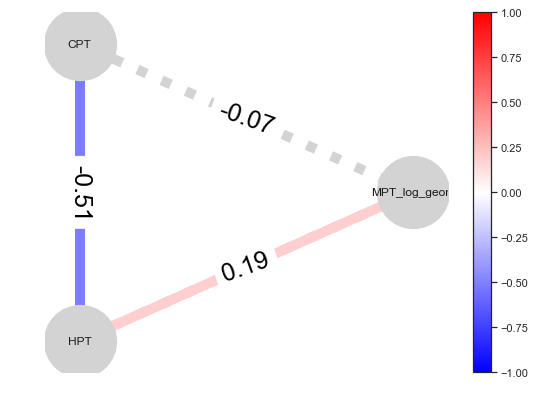

In [6]:
# Calculate the correlation between individuals. We have to transpose first, because the corr function calculate the pairwise correlations between columns.
corr = df[["HPT", "CPT", "MPT_log_geom", "study"]].corr()
corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))

# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links['value']=np.round(links['value'], decimals=2)
 
# Remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_dataframe(links_filtered, 'var1', 'var2', edge_attr='value')

significant = [(u, v) for (u, v, d) in G.edges(data=True) if np.abs(d['value']) > 0.15]
significant_value = [d['value'] for (u, v, d) in G.edges(data=True) if np.abs(d['value']) > 0.15]
nonsignificant = [(u, v) for (u, v, d) in G.edges(data=True) if np.abs(d['value']) <= 0.15]
nonsignificant_value = [d['value'] for (u, v, d) in G.edges(data=True) if np.abs(d['value']) <= 0.15]
    
# Plot the network:
pos = nx.circular_layout(G)
plt.figure(3,figsize=(7,5)) 
nx.draw(G, pos, with_labels=True, node_color='lightgray', node_size=4000,
         edge_color='lightgray', linewidths=10, width=10, style='dotted')
edges=nx.draw_networkx_edges(G, pos, edge_color=significant_value, edgelist=significant, width=10,
                             edge_cmap=plt.cm.bwr, edge_vmin=-1, edge_vmax=1)

plot=nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=nx.get_edge_attributes(G,'value'),#{('HPT','CPT'):'*',('HPT','MPT_log_geom'):'*',('CPT','MPT_log_geom'):''},
                             font_color='black', 
                             font_size=25)

colorbar=plt.colorbar(edges)


Dotted lines and light gray color mean no significance and solid lines mean significant correlation and are color-coded, according to the legend.

As shown by this plot, the correlation structure of the pain threshold data shows that:
- there is a relationship (or shared component) between the thermal thresholds (HPT and CPT), implied by a strong, significant correlation.
- there is also a relationship (or shared component) between HPT and MPT, implied by a weaker, but still significant correlation.

### Interpretation

Two interpretations are possible:
- There IS a single *shared component across all three modalities*, but we were unable to detect the CPT-MPT relationship in the current sample (e.g. because it is "abolished" by the modality-specific and noise components, which are of different magnitude in various modalities)
- There is NO shared component between CPT and MPT, but there is one shared component between HPT and CPT and another between HPT and MPT. 

The current analysis is unable to decide between the above options. 

**Solution: ** unsupervised dimension reduction analysis (Step 3). 

## Step 3. Principal Component Analysis

We perform a Principal Component Analysis (PCA) and investigate the contribution ("loadings") of each modality to the principal components of the data in order to determine, which interpretation from above fits the data better.
Significance of contributions will be investigated by a permutations test.

**Possible outcomes and interpretations:**

- If we find a principal component that holds significant contributions from all three variables, it can be consaidered as an evodence for a common shared component.
- If to all of the principal components there is at least one modality that does not have a significant contribution, then there is, most probably, no component that is shared across *all three* modalities, or the variance explained by this component is too small to be captured by PCA.

Let's do PCA on the original (unpermuted) data and plot the contribution-matrix (loadings).

,PC1,PC2,PC3
HPT,0.745046,0.086474,0.239769
CPT,0.424109,0.158420,0.385858
MPT,0.221024,0.595476,0.067835


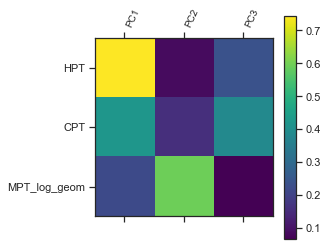

In [7]:
scaler = RobustScaler()
df_pca=df[["HPT", "CPT", "MPT_log_geom"]]
df_pca.loc[:,'HPT'] *= -1  # to align directions of scsales
df_pca.loc[:,'MPT_log_geom'] *= -1  # to align directions of scsales
data_rescaled = scaler.fit_transform(df_pca)
pca = PCA(n_components=3)
pca.fit(data_rescaled)
principal_components=pca.transform(data_rescaled)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.matshow(np.abs(loadings),cmap='viridis')
plt.xticks([0,1,2],['PC1','PC2','PC3'],fontsize=10, rotation=65,ha='left')
plt.colorbar()
plt.yticks(range(len(df[["HPT", "CPT", "MPT_log_geom"]].columns.values)),
           df[["HPT", "CPT", "MPT_log_geom"]].columns.values)
#plt.tight_layout()
original_loadings=loadings
pd.DataFrame(np.abs(original_loadings), columns=['PC1','PC2','PC3'], index=["HPT", "CPT", "MPT"])

Principal component 1 (PC1) is obviously driven by the thermal thersholds (HPT and CPT), however it is of question, whether the contribution of MPT to PC1 is significant.

Therefore, we permute MPT and repeat the PCA many times to construct a p-value for the above question.

In [9]:
np.random.seed(0) # for reproducibility
numperms=1000 # set to 10000 for more accurate results
all_loadings=np.zeros(numperms)
# permute data
for iperm in tqdm(range(numperms)):
    data_rescaled_perm=pd.DataFrame()
    data_rescaled_perm['HPT'] = data_rescaled[:,0]
    data_rescaled_perm['CPT'] = data_rescaled[:,1]
    data_rescaled_perm['MPT_log_geom'] = np.random.permutation(data_rescaled[:,2])

    data_rescaled_perm
    pca = PCA(n_components=3)
    pca.fit(data_rescaled_perm)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    # contribution of the permuted MPT to PC1
    all_loadings[iperm] = loadings[2,0] 
    
# calculate p-value:
orignal_loading_mpt=original_loadings[2,0]
print("p = ", str(np.sum(all_loadings > orignal_loading_mpt)/len(all_loadings)))


100%|██████████| 1000/1000 [00:03<00:00, 263.71it/s]

p =  0.05


### Results
The permutation-based p-value of the PCA is p=0.049 (with 10000 permutations), providing evidence for a **shared component across all three modalities**.

### Interpretation

The most plausible interpretation of these results is that there is a "thermal component" shared between HPT and CPT and another "general component" which is shared across all three modalities.

**@Matthias: Here, again, we need to extend the interpretatioin with some neurobiological background**

While in our paper, the latter component is of interest, the mean composite pain sensitivity, as defined by Zunhammer et al., 2016, most probably captures both the "thermal" and the "general" components, therby meaning a potential bias in the proposed prediction approach (RPN-signature).

To characterise the above mentioned bias, below we evaluate, whether the "Zunhammer-score" and the score predicted by the RPN-signature is correlated with all thre modalities.

# Question Q2. Do the the composite pain sensitivity score of (Zunhammer et al., 2016), similarly to PC1, capture the identified modality-independent component?

### Step 1. PC1 vs. the "mean pain sensitivity score" by (Zunhammer et al., 2016)

First we test, to what extent the the "mean pain sensitivity score" by (Zunhammer et al., 2016) (used in our study as prediction target) correlates to PC1 (defined above).

** Possible outcomes and interpretations:**
- Due to the significant collinearity (Q1, step 2) and the significant internal consistency (Q1, step 1) of the pain threshold measures, PC1 is most probably very strongly correlated with the mean allowing for using the mean and PC1 interchangeably, and as prediction target in our study.

In [12]:
# we define a function for computing p-values with permutation test, as this will be applied multiple times
def permtest(A, B, nameA="A", nameB="B", numperm=10000):
    cor=np.corrcoef(A, B)[0,1]
    print("cor(" + nameA + "," + nameB + ") = " + str(cor) )
    p_value = permutation_test(A, B,
                           method='approximate',
                           func=lambda x, y: np.sign(cor)*np.corrcoef(x, y)[1][0],
                           num_rounds=numperm,
                           seed=0)
    if p_value==0:
        print("Permuation-based p < " + str(1.0/numperm))
    else:
        print("Permuation-based p = " + str(p_value))
    
permtest(df['mean_QST_pain_sensitivity'], principal_components[:,0], "Zunhammer-score", "PC1")   

cor(Zunhammer-score,PC1) = 0.9259546424719092
Permuation-based p < 0.0001


### Result

As expected, the mean strongly correlates (R=0.93, p<<0.001) with the first principal component, therefore, most probably, captures the shared component of interest.

Let us plot the pain thresholds, together with PC1 and the "mean pain sensitivity score" by (Zunhammer et al., 2016) as a network:

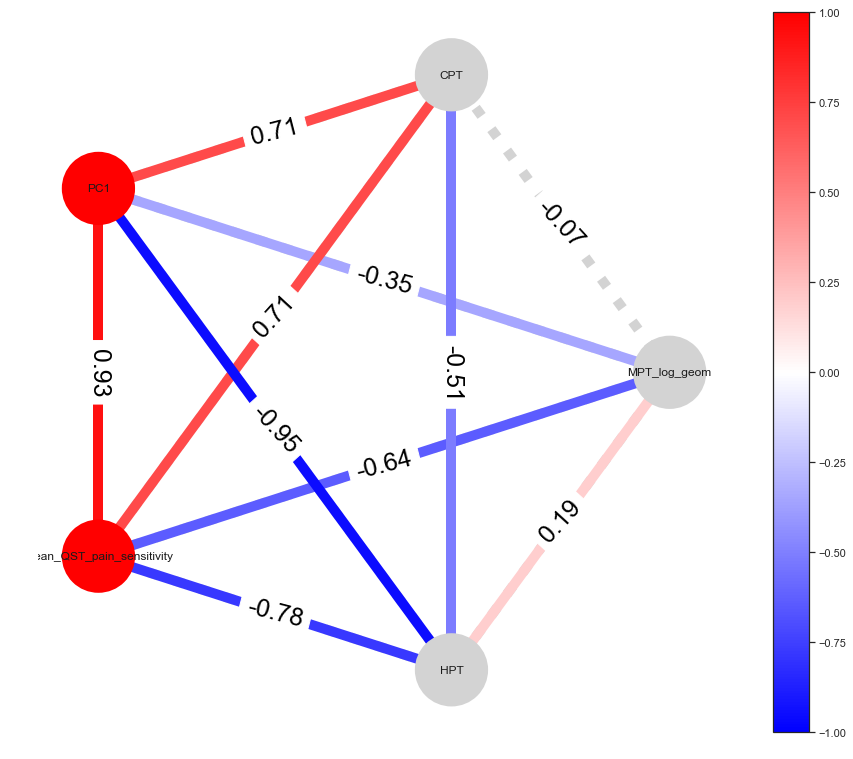

In [15]:
# Calculate the correlation between individuals. We have to transpose first, because the corr function calculate the pairwise correlations between columns.
tmpdf=df[["HPT", "CPT", "MPT_log_geom", "mean_QST_pain_sensitivity"]]
tmpdf['PC1']=principal_components[:,0]
tmpdf=tmpdf[["HPT", "CPT", "MPT_log_geom", "mean_QST_pain_sensitivity", 'PC1']] # just to fix order of columns
corr = tmpdf.corr()
corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))

# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links['value']=np.round(links['value'], decimals=2)
 
# Remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['var1'] != links['var2']) ]
 
# Build your graph
G=nx.from_pandas_dataframe(links_filtered, 'var1', 'var2', edge_attr='value')

significant = [(u, v) for (u, v, d) in G.edges(data=True) if np.abs(d['value']) > 0.15]
significant_value = [d['value'] for (u, v, d) in G.edges(data=True) if np.abs(d['value']) > 0.15]
nonsignificant = [(u, v) for (u, v, d) in G.edges(data=True) if np.abs(d['value']) <= 0.15]
nonsignificant_value = [d['value'] for (u, v, d) in G.edges(data=True) if np.abs(d['value']) <= 0.15]
    
# Plot the network:
pos = nx.circular_layout(G)
plt.figure(3,figsize=(12,10)) 
nx.draw(G, pos, with_labels=True, node_color=['lightgray', 'lightgray', 'red', 'red', 'lightgray'],
        node_size=4000, edge_color='lightgray', linewidths=10, width=10, style='dotted')
edges=nx.draw_networkx_edges(G, pos, edge_color=significant_value, edgelist=significant, width=10,
                             edge_cmap=plt.cm.bwr, edge_vmin=-1, edge_vmax=1)

plot=nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=nx.get_edge_attributes(G,'value'),#{('HPT','CPT'):'*',('HPT','MPT_log_geom'):'*',('CPT','MPT_log_geom'):''},
                             font_color='black', 
                             font_size=25)

colorbar=plt.colorbar(edges)



As previously, dotted lines mean no significance (only one correlation, between MPT and CPT) and solid lines mean significant correlation.

### Interpretation

As expected, the composite pain sensitivity scores (red nodes), namely PC1 and the the "mean pain sensitivity score" by (Zunhammer et al., 2016) (denoted as "mean_QST_pain_sensitivity" on the figure) are *significantly correlated with all modalities*, including MPT.
This suggests, that similarly to PC1 (as shown above) the Zunhammer-score is also able to capture the shared component of interest.

Let's look at the single data points to confirm that correlations between the Zunhammer-score and the single modalities are NOT driven by e.g. outliers.

Correlation with the pain sensitivity score of (Zunhammer et al., 2016):
cor(HPT,pain sensitivity (Zunhammer)) = -0.7797640399729854
Permuation-based p < 0.0001
cor(CPT,pain sensitivity (Zunhammer)) = 0.7055498458988412
Permuation-based p < 0.0001
cor(MPT,pain sensitivity (Zunhammer)) = -0.6396260726198744
Permuation-based p < 0.0001


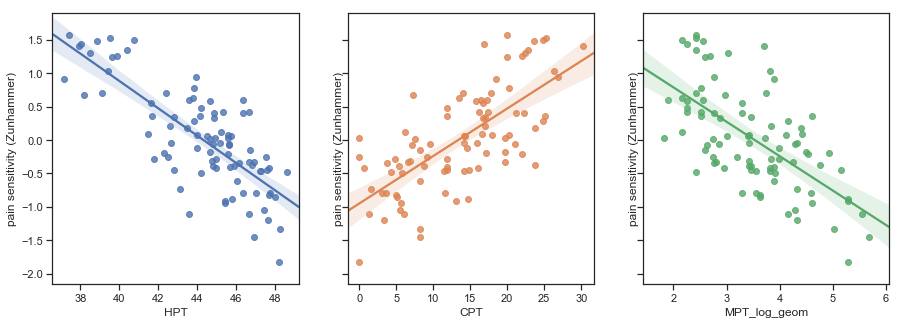

In [17]:
# Plot correlation with the "Zunhammer-score"
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.regplot(x=df['HPT'], y=df['mean_QST_pain_sensitivity'], ax=ax1)
ax1.set_ylabel('pain sensitivity (Zunhammer)')
sns.regplot(x=df['CPT'], y=df['mean_QST_pain_sensitivity'], ax=ax2)
ax2.set_ylabel('pain sensitivity (Zunhammer)')
sns.regplot(x=df['MPT_log_geom'], y=df['mean_QST_pain_sensitivity'], ax=ax3)
ax3.set_ylabel('pain sensitivity (Zunhammer)')
ran=np.max(df['mean_QST_pain_sensitivity'])-np.min(df['mean_QST_pain_sensitivity'])
plt.ylim(np.min(df['mean_QST_pain_sensitivity'])-0.1*ran, np.max(df['mean_QST_pain_sensitivity'])+0.1*ran)
ran=np.max(df['MPT_log_geom'])-np.min(df['MPT_log_geom'])
ax3.set_xlim(np.min(df['MPT_log_geom'])-0.1*ran,np.max(df['MPT_log_geom'])+0.1*ran)


# compute p-values with permutation test 
print("Correlation with the pain sensitivity score of (Zunhammer et al., 2016):")
permtest(df['HPT'], df['mean_QST_pain_sensitivity'], 'HPT', 'pain sensitivity (Zunhammer)')
permtest(df['CPT'], df['mean_QST_pain_sensitivity'], 'CPT', 'pain sensitivity (Zunhammer)')
permtest(df['MPT_log_geom'], df['mean_QST_pain_sensitivity'], 'MPT', 'pain sensitivity (Zunhammer)')

# Question Q3. Do we have evidence that the prediction (the RPN-score, trained using the "mean pain sensitivity score" by (Zunhammer et al., 2016)) captures the identified shared, modality-independent component? 

**So far, we have shown that:**
- the all three modalities (HPT, CPT and MPT) significantly contribute to the first principal component (PC1) of the data, pointing to the existence of a shared, modality-independent component of pain sensitivity.
- the "mean pain sensitivity score" by (Zunhammer et al., 2016), used in our study as a proxy for modality-independent pain sensitivity and prediction target, very strongly correlates with PC1, therefore, most probably incorporates  the shared, modality-independent component of interest

** *NOTE:* ** The RPN-signature was trained with the the "mean pain sensitivity score" by (Zunhammer et al., 2016) and was "blind" to the single scores, already during the training procedure.

At this point, however, we cannot exclude the possibility, that the the "mean pain sensitivity score" by (Zunhammer et al., 2016) is dominated by components other than the modality-independent component of interest (e.g. thermal modality-specific or noise) so such a great extent that using it as a prediction target ends up in loosing the "modality-independentness" and remains predictive to only one or two modalities.

This would make the RPN-signature unstable for adding or removing a sensory modality from the composite score.

We test, how well the *composite score-based* RPN prediction generalizes to the single modalities by leaving out modalities when computing the observed composite score. Specifically, this involves an analysis of leaving out one modality (Step 1) and leaving out two modalities, i.e. retaining only one modality.

### Step 1.  "Leave-one-modality-out" analysis

In this analysis, we calculate two-modality summary scores with the same method used for the Zunhammer-score.
Comparing these "leave-one-modality-out" scores to the RPN-score provides insights into the generalizability of the RPN-signature to combinations of different modalities and potentially, adding a new modality.

Correlation with the RPN-score:
cor(composite(HPT,CPT),RPN-score) = 0.4575562457450685
Permuation-based p < 0.0001
cor(composite(HPT,MPT),RPN-score) = 0.4291506440039318
Permuation-based p < 0.0001
cor(composite(CPT,MPT),RPN-score) = 0.40012762722771095
Permuation-based p < 0.0001


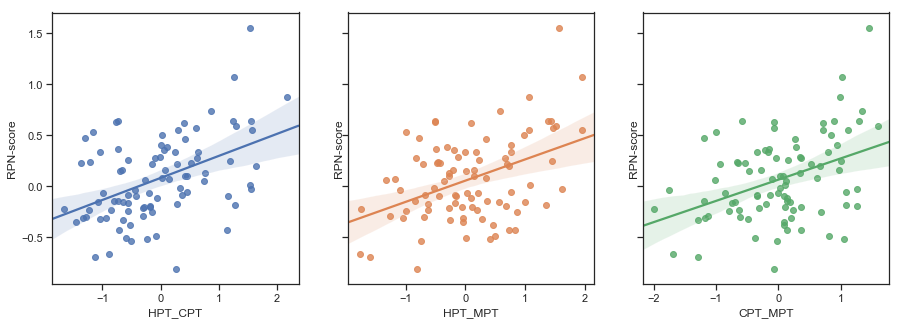

In [20]:
# calculate leave-one-modality-out summary scores (analogously to the method used by Zunhammer et al.)
# means and standard deviations from Study1 (Bochum-sample):
# these values are hard-coded into the calculation of the score of (Zunhammer et al., 2016),
# so that its calculation is independent of the data at hand
b_hpt_mean=44.21297
b_hpt_sd=2.799718
b_cpt_mean=14.35385
b_cpt_sd=7.595601
b_mpt_mean=3.617695
b_mpt_sd=0.801178

hpt_scaled=-(df['HPT']-b_hpt_mean)/b_hpt_sd
cpt_scaled=(df['CPT']-b_cpt_mean)/b_cpt_sd
mpt_scaled=-(df['MPT_log_geom']-b_mpt_mean)/b_mpt_sd

df_lomo=df #lomo:leave-one-modality-out
df['HPT_CPT']=(hpt_scaled+cpt_scaled)/2
df['HPT_MPT']=(hpt_scaled+mpt_scaled)/2
df['CPT_MPT']=(cpt_scaled+mpt_scaled)/2

# Plot correlation with the "RPN-score"
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.regplot(x=df['HPT_CPT'], y=df['prediction'], ax=ax1)
sns.regplot(x=df['HPT_MPT'], y=df['prediction'], ax=ax2)
sns.regplot(x=df['CPT_MPT'], y=df['prediction'], ax=ax3)
ax1.set_ylabel('RPN-score')
ax2.set_ylabel('RPN-score')
ax3.set_ylabel('RPN-score')

# compute p-values with permutation test
print("Correlation with the RPN-score:")
permtest(df['HPT_CPT'], df['prediction'], 'composite(HPT,CPT)', 'RPN-score')
permtest(df['HPT_MPT'], df['prediction'], 'composite(HPT,MPT)', 'RPN-score')
permtest(df['CPT_MPT'], df['prediction'], 'composite(CPT,MPT)', 'RPN-score')

### Result

All possible leave-one-modality-out scores were significantly predicted by the RPN-score.

### Interpretation

The RPN-signature is NOT driven by one modality only, and stays robust for different definitions of "composite pain sensitivity".

### Step 2.  "Leave-two-modalities-out" analysis
Leaving out two modalities equals with simply testing the relationship of the composite RPN-score with the single modalities (HPT, CPT and MPT)

Correlation with the RPN-score:
cor(HPT,RPN-score) = -0.43644372163377854
Permuation-based p < 0.0001
cor(CPT,RPN-score) = 0.35617457477513276
Permuation-based p = 0.0005
cor(MPT,RPN-score) = -0.24024492612674364
Permuation-based p = 0.0129


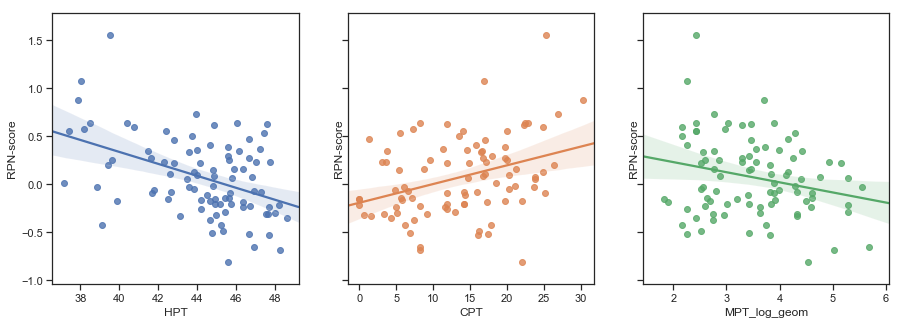

In [21]:
# Plot correlation with the "RPN-score"
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.regplot(x=df['HPT'], y=df['prediction'], ax=ax1)
sns.regplot(x=df['CPT'], y=df['prediction'], ax=ax2)
sns.regplot(x=df['MPT_log_geom'], y=df['prediction'], ax=ax3)
ran=np.max(df['prediction'])-np.min(df['prediction'])
plt.ylim(np.min(df['prediction'])-0.1*ran, np.max(df['prediction'])+0.1*ran)
ran=np.max(df['MPT_log_geom'])-np.min(df['MPT_log_geom'])
ax3.set_xlim(np.min(df['MPT_log_geom'])-0.1*ran,np.max(df['MPT_log_geom'])+0.1*ran)
ax1.set_ylabel('RPN-score')
ax2.set_ylabel('RPN-score')
ax3.set_ylabel('RPN-score')

# compute p-values with permutation test
print("Correlation with the RPN-score:")
permtest(df['HPT'], df['prediction'], 'HPT', 'RPN-score')
permtest(df['CPT'], df['prediction'], 'CPT', 'RPN-score')
permtest(df['MPT_log_geom'], df['prediction'], 'MPT', 'RPN-score')

### Result

All possible "leave-two-modality-out" scores, i.e. all three pain modalities were significantly predicted by RPN-score.

### Interpretation

The RPN-signature is NOT exclusively driven by any combination of two modalities, specifically, not only driven by the thermal thresholds.
The RPN-score holds predictive value for all modalities, even though it was trained to predict the modality-independent composite pain sensitivity score by (Zunhammer et al., 2016).


# Question Q4. To what extent is the RPN-score biased towards any of the modalities? Is its correlation with the single thresholds lower than excpeted from its correlation to the Zunhammer-score?

This analysis aims to exclude the possibility that the RPN-score is biased e.g. towards thermal thresholds.

We will employ "simulated" RPN-scores that are constructed by adding Gaussian noise to the pain sensitivity score of (Zunhammer et al, 2016), so that the correlation of these simulated scores with the original pain sensitivity score equals to its correlation to the RPN-score. For the sake of simplicity, we refer to these simulates scores as "simulated RPN-scores".

The correlation of many simulated RPN-scores to the single pain thresholds (HPT, CPT, MPT) will be used to construct a null distribution for these correlations. Then, the actual "RPN-score -- single thresholds" correlations will be contrasted to these null distributions to obtain p-values. The test is one sided, testing for "negative bias" (smaller correlation than expected from the null).

**Possible outcomes and interpretations:**
- a significant p-value implies a strong bias against the given modality, meaning that the the degree to which the RPN-signature generalizes to the single pain thresholds significantly differs from what we can expect given its correlation to the pain sensitivity score by Zunhammer et al..
- p-values greater than the alpha-level (p>0.05) means that our data provides *no evidence* for significant bias of the RPN-score towards any of the single pain modalities.

100%|██████████| 1000/1000 [00:01<00:00, 729.02it/s]


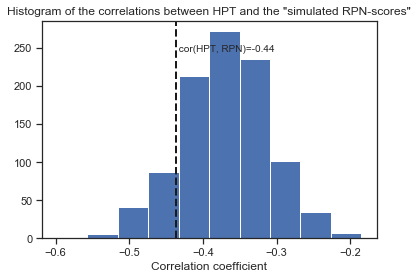

p =  0.873


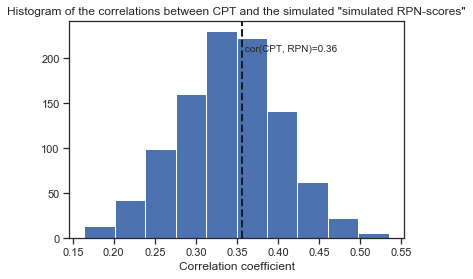

p =  0.583


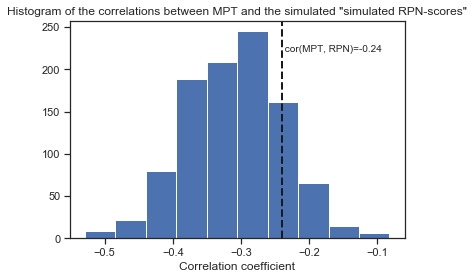

p =  0.166


In [23]:
old_df=df
df=df#study3.dropna()

cor_Zunhammer_rpn = np.corrcoef(df['mean_QST_pain_sensitivity'], df['prediction'])[0,1]

np.random.seed(1)
num_sim=1000

# a nice tricky function to genberate random noisy Zunhammers: variables with a given correlation to the Zunhammer-score
# ported to python from: https://stats.stackexchange.com/questions/15011/generate-a-random-variable-with-a-defined-correlation-to-an-existing-variables
def get_noisy_Zunhammer(rho=cor_Zunhammer_rpn, y=df['mean_QST_pain_sensitivity'], x=None, seed=None):
    if (not x):
        if seed is not None:
            np.random.seed(seed)
        x = np.random.normal(0,1,len(y))
    y=np.array(y)
    x=np.array(x)
    y_perp = sm.OLS(x,sm.tools.tools.add_constant(y)).fit().resid
    return( rho * np.std(y_perp, ddof=1) * y + y_perp * np.std(y, ddof=1) * np.sqrt(1 - rho**2.0) )

rhos_noisyZunhammer_Zunhammer=np.zeros(num_sim)
rhos_noisyZunhammer_HPT=np.zeros(num_sim)
rhos_noisyZunhammer_CPT=np.zeros(num_sim)
rhos_noisyZunhammer_MPT=np.zeros(num_sim)

Zunhammer_std = (df['mean_QST_pain_sensitivity']-np.mean(df['mean_QST_pain_sensitivity']))/-np.std(df['mean_QST_pain_sensitivity'])

# simulate noisy Zunhammers
for sim_i in tqdm(range(num_sim)):
    # cereate a "noisy Zunhammer"
    noisy_Zunhammer=get_noisy_Zunhammer()
    # calculate the correlation of the noisy Zunhammer and the observed Zunhammer-score
    rhos_noisyZunhammer_Zunhammer[sim_i]=np.corrcoef(df['mean_QST_pain_sensitivity'], noisy_Zunhammer)[0,1]
    # calculate the correlation between the noisy Zunhammer and the single pain thershodls
    rhos_noisyZunhammer_HPT[sim_i]=np.corrcoef(df['HPT'], noisy_Zunhammer)[0,1]
    rhos_noisyZunhammer_CPT[sim_i]=np.corrcoef(df['CPT'], noisy_Zunhammer)[0,1]
    rhos_noisyZunhammer_MPT[sim_i]=np.corrcoef(df['MPT_log_geom'], noisy_Zunhammer)[0,1]

    
#assess p-values based on the null distributions of correlations between the noisy Zunhammers and HPT
cor_HPT_RPN=np.corrcoef(df['HPT'], df['prediction'])[0,1]
hist=plt.hist(rhos_noisyZunhammer_HPT)
plt.title("Histogram of the correlations between HPT and the \"simulated RPN-scores\"")
plt.xlabel("Correlation coefficient")
plt.axvline(cor_HPT_RPN, color='k', linestyle='dashed', linewidth=2)
text=plt.text(cor_HPT_RPN, np.max(hist[0])*0.9, " cor(HPT, RPN)=" + str(np.round(cor_HPT_RPN, 2)))
plt.show()
print("p = ", str(np.sum(rhos_noisyZunhammer_HPT > cor_HPT_RPN)/num_sim) )


#assess p-values based on the null distributions of correlations between the noisy Zunhammers and CPT
cor_CPT_RPN=np.corrcoef(df['CPT'], df['prediction'])[0,1]
hist=plt.hist(rhos_noisyZunhammer_CPT)
plt.title("Histogram of the correlations between CPT and the simulated \"simulated RPN-scores\"")
plt.xlabel("Correlation coefficient")
plt.axvline(cor_CPT_RPN, color='k', linestyle='dashed', linewidth=2)
text=plt.text(cor_CPT_RPN, np.max(hist[0])*0.9, " cor(CPT, RPN)=" + str(np.round(cor_CPT_RPN, 2)))
plt.show()
print("p = ", str(np.sum(rhos_noisyZunhammer_CPT < cor_CPT_RPN)/num_sim) )


#assess p-values based on the null distributions of correlations between the noisy Zunhammers and MPT
cor_MPT_RPN=np.corrcoef(df['MPT_log_geom'], df['prediction'])[0,1]
hist=plt.hist(rhos_noisyZunhammer_MPT)
plt.title("Histogram of the correlations between MPT and the simulated \"simulated RPN-scores\"")
plt.xlabel("Correlation coefficient")
plt.axvline(cor_MPT_RPN, color='k', linestyle='dashed', linewidth=2)
text=plt.text(cor_MPT_RPN, np.max(hist[0])*0.9, " cor(MPT, RPN)=" + str(np.round(cor_MPT_RPN, 2)))
plt.show()
print("p = ", str(np.sum(rhos_noisyZunhammer_MPT > cor_MPT_RPN)/num_sim) )

df=old_df

Dashed lines imply the actual correlation of the given pain threshold with the RPN-signature.


### Results

All p-values are gerater than 0.05.

### Interpretation

**We found no evidence of negative bias towards any of the sensory modalities.**

# Conclusion

In this python notebook, we have performed a multi-stage analysis to investigate the rationale for using the composite pain sensitivity score as defined by (Zunhammer et al., 2016) for predictive modelling purposes.

We have found that:
- (Q1) There IS a common, modality-independent component shared across the investigated pain modalities.
- (Q2) The the composite score of (Zunhammer et al., 2016) does capture this shared, modality-independent component.
- (Q3) The prediction of the RPN-signature (the RPN-score) also captures the identified modality-independent component of pain sensitivity.
- (Q4) The RPN-score was not found to be significantly biased towards/against any of the modalities.

We conclude, that the RPN-score represents a modality independent component of pain sensitivity.

**@Matthias: some "more biologocal" conclusion?**



# References

**(Babbie, 2016)** Babbie ER. The basics of social research. Cengage learning; page 158. 2013.

**(Bobko et al, 2007)** Bobko P, Roth PL, Buster MA. The usefulness of unit weights in creating composite scores: A literature review, application to content validity, and meta-analysis. Organizational Research Methods. 2007 Oct;10(4):689-709.

**(Haugen et al., 2010)** Haugen IK, Slatkowsky-Christensen B, Lessem J, Kvien TK. The responsiveness of joint counts, patient-reported measures and proposed composite scores in hand osteoarthritis: analyses from a placebo-controlled trial. Annals of the rheumatic diseases. 2010 Aug 1;69(8):1436-40.

**(Jensen et al., 1999)** Jensen MP, Turner JA, Romano JM, Fisher LD. Comparative reliability and validity of chronic pain intensity measures. Pain. 1999 Nov 1;83(2):157-62.

**(Jensen et al., 2002)** Jensen MP, Chen C, Brugger AM. Postsurgical pain outcome assessment. Pain. 2002 Sep 1;99(1-2):101-9.

**(O’Neill et al., 2014)** O’Neill S, Manniche C, Graven-Nielsen T, Arendt-Nielsen L. Association between a composite score of pain sensitivity and clinical parameters in low-back pain. The Clinical journal of pain. 2014 Oct 1;30(10):831-8.

**(Rolke et al., 2006)** Rolke R, Baron R, Maier CA, Tölle TR, Treede RD, Beyer A, Binder A, Birbaumer N, Birklein F, Bötefür IC, Braune S. Quantitative sensory testing in the German Research Network on Neuropathic Pain (DFNS): standardized protocol and reference values. Pain. 2006 Aug 1;123(3):231-43.

**(Song et al., 2013)** Song MK, Lin FC, Ward SE, Fine JP. Composite variables: when and how. Nursing research. 2013 Jan;62(1):45.

**(Starkweather et al., 2016)** Starkweather AR, Heineman A, Storey S, Rubia G, Lyon DE, Greenspan J, Dorsey SG. Methods to measure peripheral and central sensitization using quantitative sensory testing: A focus on individuals with low back pain. Applied Nursing Research. 2016 Feb 1;29:237-41.

**(Victor et al., 2008)** Victor TW, Jensen MP, Gammaitoni AR, Gould EM, White RE, Galer BS. The dimensions of pain quality: factor analysis of the Pain Quality Assessment Scale. The Clinical journal of pain. 2008 Jul 1;24(6):550-5.

**(Zinbarg et al., 2006)** Zinbarg RE, Yovel I, Revelle W, McDonald RP. Estimating generalizability to a latent variable common to all of a scale's indicators: A comparison of estimators for ωh. Applied Psychological Measurement. 2006 Mar;30(2):121-44.

**(Zunhammer et al., 2016)** Zunhammer M, Schweizer LM, Witte V, Harris RE, Bingel U, Schmidt-Wilcke T. Combined glutamate and glutamine levels in pain-processing brain regions are associated with individual pain sensitivity. Pain. 2016 Oct 1;157(10):2248-56.


